#### Trenutni zadatak je treniranje na temelju podataka iz 9. mjeseca i predviđanje potrošnje prvih 10 dana 10. mjeseca

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Učitaj podatke za opterećenje

In [84]:
# Ucitaj podatke
df_total = pd.read_excel('Arhiva_10_2021.xlsx', sheet_name=['07.','08.', '09.', '10.'], usecols=[0,1,2], converters={'datum':str, 'vrijeme':str}, names=['datum', 'vrijeme', 'Potrošnja'])

In [85]:
df = pd.concat([df_total['07.'], df_total['08.'], df_total['09.'], df_total['10.'].loc[0:24*14-1]])

In [86]:
df

,datum,vrijeme,Potrošnja
0,2021-07-01 00:00:00,00:00:00,1776.67500
1,2021-07-01 00:00:00,01:00:00,1613.35100
2,2021-07-01 00:00:00,02:00:00,1534.29500
3,2021-07-01 00:00:00,03:00:00,1491.38000
4,2021-07-01 00:00:00,04:00:00,1493.04500
...,...,...,...
331,2021-10-14 00:00:00,1900-01-13 19:00:00,2405.71375
332,2021-10-14 00:00:00,1900-01-13 20:00:00,2340.17425
333,2021-10-14 00:00:00,1900-01-13 21:00:00,2167.23000
334,2021-10-14 00:00:00,1900-01-13 22:00:00,2013.76125


Napomena:
    
Bilo je mnogo problema s parsiranjem datuma zbog nekonzistentnosti zapisa u .xlsx fileu. Konkretno, prvih 24 vrijednosti sadrži zapis u AM/PM formatu, dok ostali ne sadrže. Zbog toga Pandas automatski dodaje vrijednost datuma za taj stupac, počevši od 1900. godine. Funkcije 'to_datetime' i slične nije bilo moguće koristiti jer se varijabla 'vrijeme' opisala kao tip 'object' i 'datetime.time'. Zbog toga sam dodao argument 'converters' kako bi to spriječio.

In [87]:
df['vrijeme'] = df['vrijeme'].str.split(' ')

In [88]:
df['vrijeme'] = df['vrijeme'].map(lambda x : x[-1])

#### Postavi index tipa datetime

In [89]:
df['Datetime'] = pd.to_datetime(df['datum'] + ' ' + df['vrijeme'])

In [90]:
df = df.set_index('Datetime')

In [91]:
df = df.drop(['datum','vrijeme'], axis=1)

In [92]:
df

,Potrošnja
Datetime,
2021-07-01 00:00:00,1776.67500
2021-07-01 01:00:00,1613.35100
2021-07-01 02:00:00,1534.29500
2021-07-01 03:00:00,1491.38000
2021-07-01 04:00:00,1493.04500
...,...
2021-10-14 19:00:00,2405.71375
2021-10-14 20:00:00,2340.17425
2021-10-14 21:00:00,2167.23000


<AxesSubplot:title={'center':'Krivulja opterećenja distribucijskog sustava [MWh]'}, xlabel='Vrijeme', ylabel='[MWh]'>

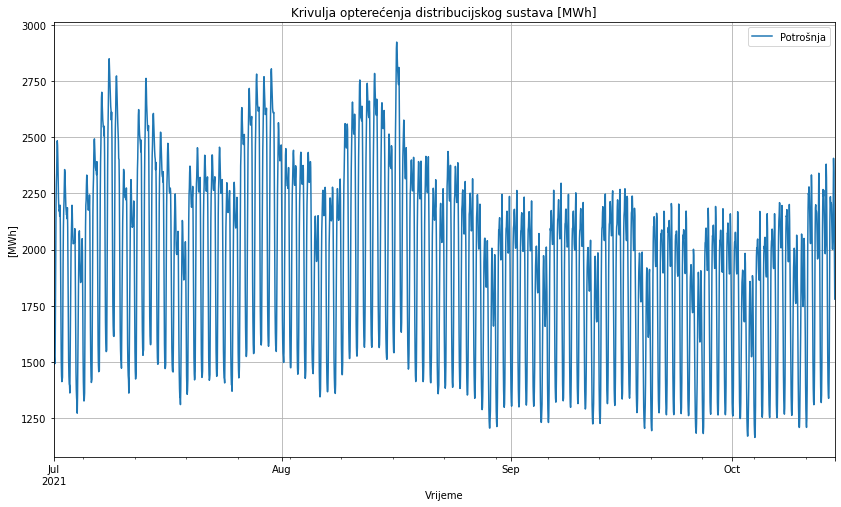

In [93]:
df.plot(use_index=True, title='Krivulja opterećenja distribucijskog sustava [MWh]', figsize=(14,8), grid=True, legend=True, ylabel='[MWh]', xlabel='Vrijeme')

Zanima me koja je srednja vrijednost za svaki sat u danu?

<AxesSubplot:xlabel='Sati', ylabel='MWh'>

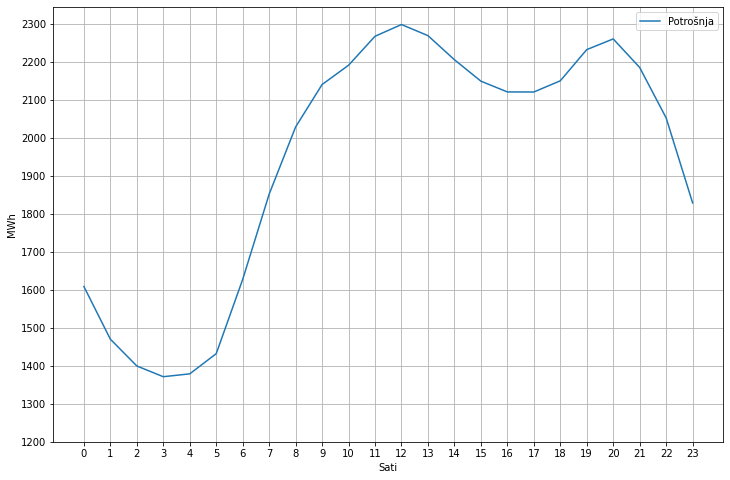

In [94]:
df.groupby(df.index.hour)['Potrošnja'].mean().plot(kind='line', xlabel='Sati', ylabel='MWh', legend=True, grid=True, figsize=(12,8), xticks = np.arange(0, 24, step=1), yticks=np.arange(1200, 2400, 100))

Ovdje sam koristio datetime kao index što omogućava jednostavno grupiranje po satima.

#### Napomena

Budući da je drukčija razina granularnosti (imamo potrošnju energije izraženu u satima i prosječnu dnevnu temperaturu), odlučio sam se na dnevnu agregaciju potrošnje. Razlog za to je da ćemo prilikom predviđanja na raspolaganju imati očekivanu prosječnu dnevnu temperaturu, a ne satnu. 

In [95]:
df = df.groupby(pd.Grouper(freq='D')).mean()

<AxesSubplot:xlabel='Datetime'>

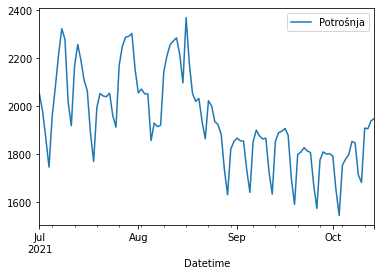

In [96]:
df.plot()

### Web scrapping

TO DO kako bi se trebalo, za sada sam manualno uzeo podatke prosječne dnevne temperature za 4 najveća HR grada (link: https://crd.meteoadriatic.net/statistics)

In [97]:
# Ucitaj podatke
df_temp_total = pd.read_excel('temperatura.xlsx', sheet_name=['7.mjesec', '8.mjesec', '9.mjesec', '10.mjesec'])

In [98]:
df_temp = pd.concat([df_temp_total['7.mjesec'], df_temp_total['8.mjesec'], df_temp_total['9.mjesec'], df_temp_total['10.mjesec'].iloc[0:14]])

In [99]:
df_temp;

In [100]:
df_temp['Datetime'] = pd.to_datetime(df_temp['Vrijeme'])

In [101]:
df_temp = df_temp.set_index('Datetime')

In [102]:
df_temp = df_temp.drop(['Vrijeme'], axis=1)

In [103]:
df_temp['Prosjek'] = df_temp.mean(axis=1).round(2)

In [104]:
df_temp

,Zagreb_temperatura,Split_temperatura,Osijek_temperatura,Rijeka_temperatura,Prosjek
Datetime,,,,,
2021-07-01,17.6,23.7,20.4,22.4,21.02
2021-07-02,19.7,23.3,18.2,22.5,20.92
2021-07-03,21.6,23.5,19.9,22.8,21.95
2021-07-04,23.3,23.8,23.0,23.8,23.48
2021-07-05,24.1,24.2,21.7,24.0,23.50
...,...,...,...,...,...
2021-10-10,9.8,16.6,9.0,11.3,11.68
2021-10-11,9.2,16.3,8.8,12.8,11.77
2021-10-12,9.0,14.5,7.0,13.9,11.10


In [105]:
# Concat tables horizontally
df_concat = pd.concat([df, df_temp['Prosjek']], axis=1)
df_concat

,Potrošnja,Prosjek
Datetime,,
2021-07-01,2050.085042,21.02
2021-07-02,1978.027458,20.92
2021-07-03,1864.896417,21.95
2021-07-04,1745.649292,23.48
2021-07-05,1958.602875,23.50
...,...,...
2021-10-10,1681.488542,11.68
2021-10-11,1908.251177,11.77
2021-10-12,1905.534615,11.10


### Stacionarnost

#### Augmented Dickey-Fuller test

Provodim ADF test za stacionarnost. ADF test postavlja sljedeće hipoteze:
* Null hipoteza ($H_0$): Postoji [unit root](https://en.wikipedia.org/wiki/Unit_root) (a.k.a. vremenski nizovi nisu stacionarni)
* Alternativna hipoteza ($H_1$): Vremenski nizovi su stacionarni (ili trend-stacionarni)

Provodim ADF test:

In [106]:
from statsmodels.tsa.stattools import adfuller

print('ADF test za potrošnju:')
display(adfuller(df_concat['Potrošnja']))

print('ADF test za prosjek temperature:')
display(adfuller(df_concat['Prosjek']))

ADF test za potrošnju:


(-0.9527049185885226,
 0.7701211245747801,
 11,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 1029.1964112898386)

ADF test za prosjek temperature:


(-0.95986676201646,
 0.7676192148423626,
 0,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 359.11707806170386)

Kao što vidimo, p value debelo je iznad 0.05, što znači da ne možemo odbaciti NULL hipotezu.

#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test

Provodim KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test koji postavlja suprotne hipoteze od ADF testa, tj.

* Null hipoteza ($H_0$): Vremenski nizovi su trend-stacionarni i ne postoji unit root
* Alternativna hipoteza ($H_1$): Vremenski nizovi su ne-stacionarni ili postoji unit root
    
Provodim KPSS test:

In [107]:
from statsmodels.tsa.stattools import kpss

print('KPSS test za potrošnju:')
display(kpss(df_concat['Potrošnja']))

print('KPSS test za prosjek temperature:')
display(kpss(df_concat['Prosjek']))

KPSS test za potrošnju:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.174899159278909,
 0.01,
 5,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS test za prosjek temperature:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.3538581438439359,
 0.01,
 5,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Kao što vidimo, KPSS testom odbacujemo Null hipotezu i možemo zaključiti da su vremenski nizovi ne-stacionarni ili postoji unit root.

Budući da su i ADF i KPSS test potvrdili da vremenski nizovi nisu stacionarni, radimo diferencijaciju i provjeravamo prolaze li zatim vremenski nizovi ADF i KPSS testove.

In [108]:
df_concat['Potrošnja'] = df_concat['Potrošnja'].diff(periods=1)
df_concat['Prosjek'] = df_concat['Prosjek'].diff(periods=1)

In [109]:
df_concat = df_concat.dropna()

In [110]:
print('ADF test za potrošnju:')
display(adfuller(df_concat['Potrošnja']))

print('ADF test za prosjek temperature:')
display(adfuller(df_concat['Prosjek']))

print('KPSS test za potrošnju:')
display(kpss(df_concat['Potrošnja']))

print('KPSS test za prosjek temperature:')
display(kpss(df_concat['Prosjek']))

ADF test za potrošnju:


(-2.8993439696243013,
 0.04542433808072344,
 13,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 1012.4061533583812)

ADF test za prosjek temperature:


(-7.6188670462831585,
 2.155054826030086e-11,
 2,
 102,
 {'1%': -3.4961490537199116,
  '5%': -2.8903209639580556,
  '10%': -2.5821223452518263},
 355.7666157060995)

KPSS test za potrošnju:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.05492776907274142,
 0.1,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS test za prosjek temperature:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.17035786651202794,
 0.1,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Kao što vidimo, nakon diferencijacije, i ADF i KPSS testovi pokazuju kako su vremenski nizovi stacionarni.

### Granger-Causality Test

Budući da je naš zadatak predviđanje potrošnje energije na temelju dane temperature, prvo provodimo 'Grangerov Test Kauzalnosti' kako bi vidjeli postoji li poveznica između vrijednosti temperature i potrošnje energije.

Grangerov test postavlja hipoteze:
* Null hipoteza ($H_0$): vremenski niz x (temperatura) nema utjecaja na vremenski niz y (potrošnja)
* Alternativna hipoteza ($H_1$): vremenski niz x (temperatura) ima utjecaja na vremenski niz y (potrošnja)

provodimo test:

In [111]:
from statsmodels.tsa.stattools import grangercausalitytests

granger_result = grangercausalitytests(df_concat[['Potrošnja', 'Prosjek']], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2764  , p=0.0082  , df_denom=101, df_num=1
ssr based chi2 test:   chi2=7.4925  , p=0.0062  , df=1
likelihood ratio test: chi2=7.2349  , p=0.0072  , df=1
parameter F test:         F=7.2764  , p=0.0082  , df_denom=101, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4505  , p=0.0141  , df_denom=98, df_num=2
ssr based chi2 test:   chi2=9.3551  , p=0.0093  , df=2
likelihood ratio test: chi2=8.9544  , p=0.0114  , df=2
parameter F test:         F=4.4505  , p=0.0141  , df_denom=98, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0254  , p=0.0028  , df_denom=95, df_num=3
ssr based chi2 test:   chi2=16.1870 , p=0.0010  , df=3
likelihood ratio test: chi2=15.0241 , p=0.0018  , df=3
parameter F test:         F=5.0254  , p=0.0028  , df_denom=95, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8803  , p=0.0269  , df

Kao što se vidi iz rezultata, Grangerov test vraća p<0.05 za vrijednost prvih 10 lagova za različite testove. To zapravo znači da možemo odbaciti NULL hipotezu (da temperatura nema utjecaja na potrošnju energije), i zaključiti alternativnu hipotezu, tj. da temperatura ima utjecaja na potrošnju energije. 

Zanimljivo je da je vrijednost p<0.05 za prvih 12 lagova, što zapravo znači da postoji kauzalnost između dana mjerenja temperature i povezati temperaturu i sljedećih 12 dana potrošnje energije. Moguće da je razlog to što se temperatura ne mijenja iznenadno te tijekom dužeg perioda (godišnja doba) ima približno istu vrijednost.  

Za sanity-check, provodim i Grangerov test da vidim postoji li kauzalnost potrošnje energije na temperaturu:

In [112]:
granger_result = grangercausalitytests(df_concat[['Prosjek', 'Potrošnja']], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5968  , p=0.4416  , df_denom=101, df_num=1
ssr based chi2 test:   chi2=0.6145  , p=0.4331  , df=1
likelihood ratio test: chi2=0.6127  , p=0.4338  , df=1
parameter F test:         F=0.5968  , p=0.4416  , df_denom=101, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0489  , p=0.3542  , df_denom=98, df_num=2
ssr based chi2 test:   chi2=2.2049  , p=0.3321  , df=2
likelihood ratio test: chi2=2.1816  , p=0.3359  , df=2
parameter F test:         F=1.0489  , p=0.3542  , df_denom=98, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9994  , p=0.3967  , df_denom=95, df_num=3
ssr based chi2 test:   chi2=3.2192  , p=0.3590  , df=3
likelihood ratio test: chi2=3.1695  , p=0.3662  , df=3
parameter F test:         F=0.9994  , p=0.3967  , df_denom=95, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6073  , p=0.6583  , df

Kao što vidimo, ne postoji utjecaj potrošnje na prosjek temperature.

### Treniram na temelju 9. mjeseca i predviđam za prvih 2 tjedna 10. mjeseca

In [113]:
# Split data into train - test
train = df_concat[df_concat.index < '2021-09-15']
test = df_concat[df_concat.index > '2021-09-15']

# Check shape
train.shape, test.shape
test

,Potrošnja,Prosjek
Datetime,,
2021-09-16,11.647125,-0.38
2021-09-17,-28.240885,-0.62
2021-09-18,-180.474969,-0.16
2021-09-19,-108.812250,0.03
2021-09-20,209.442031,-0.35
2021-09-21,9.629031,-0.28
2021-09-22,18.546531,-3.20
2021-09-23,-13.689896,1.33
2021-09-24,-6.765125,-1.53


### Using SARIMA for forecasting

Dekompozicija potrošnje da se vidi sezonalnost i trend

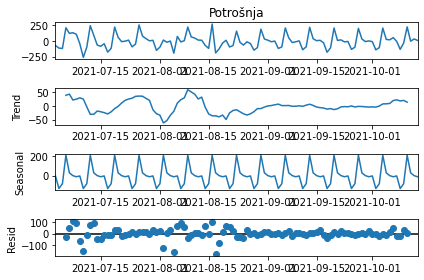

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decompose_data = seasonal_decompose(df_concat.Potrošnja, model="additive")
decompose_data.plot();

In [115]:
# Izracunaj najbolji order
from pmdarima.arima import auto_arima

auto_arima_result = auto_arima(y=df_concat['Potrošnja'], x=df_concat, trace=True, seasonal=False, information_criterion='aic')

auto_arima_result.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1276.743, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1291.537, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1293.070, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1292.394, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1277.104, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1279.104, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1277.622, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1285.444, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1280.241, Time=0.08 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 0.996 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -633.371
Date:                Fri, 10 Jun 2022   AIC                           1276.743
Time:                        16:39:12   BIC                           1290.013
Sample:                             0   HQIC                          1282.120
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0477      0.202      0.237      0.813      -0.348       0.443
ar.L2          0.2970      0.166      1.792      0.073      -0.028       0.622
ma.L1         -0.0509      0.137     -0.372      0.710      -0.318       0.217
ma.L2         -0.7750      0.111     -7.011      0.000      -0.992      -0.558
sigma2      1.006e+04   1588.921      6.334      0.000    6949.602    1.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.85   Prob(JB):                         0.80
Heteroskedasticity (H):               0.69   Skew:                             0.08
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(endog=df_concat['Potrošnja'], exog=df_concat['Prosjek'] , order=(2, 0, 2) ,seasonal_order=(0,0,0,0))

results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16235D+00    |proj g|=  4.23479D-01

At iterate    5    f=  6.02967D+00    |proj g|=  4.86105D-02

At iterate   10    f=  6.02015D+00    |proj g|=  5.16641D-02

At iterate   15    f=  6.01470D+00    |proj g|=  8.58960D-04

At iterate   20    f=  6.01406D+00    |proj g|=  4.65999D-03

At iterate   25    f=  6.01310D+00    |proj g|=  4.84769D-04

At iterate   30    f=  6.01307D+00    |proj g|=  5.85132D-03

At iterate   35    f=  6.01298D+00    |proj g|=  3.60995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/tmp/ipykernel_27841/2369365017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Potrošnja'] = results.predict(exog=test['Prosjek'], start='2021-09-16', end='2021-10-14')


<AxesSubplot:xlabel='Datetime'>

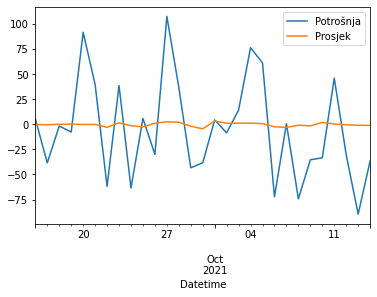

In [126]:
test['Potrošnja'] = results.predict(exog=test['Prosjek'], start='2021-09-16', end='2021-10-14')

test.plot()

<AxesSubplot:xlabel='Datetime'>

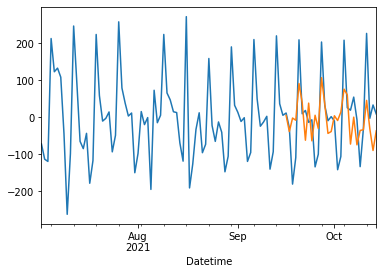

In [127]:
df_concat.Potrošnja.plot()
test.Potrošnja.plot()

Zaključak je da model možemo koristiti za predikcije

#### Normalizacija podataka

In [37]:
# Import library
from sklearn.preprocessing import MinMaxScaler

# Define min-max scaler
scaler = MinMaxScaler()

# Fit-Transform data (ali samo fit na training data, transform na oba)

normalization_min_potrosnja = df_concat[:'2021-09-30']['Potrošnja'].min()
normalization_max_potrosnja = df_concat[:'2021-09-30']['Potrošnja'].max()

normalization_min_prosjek = df_concat[:'2021-09-30']['Prosjek'].min()
normalization_max_prosjek = df_concat[:'2021-09-30']['Prosjek'].max()

normalized_df = pd.DataFrame(df_concat)

normalized_df.Potrošnja = (df_concat.Potrošnja-normalization_min_potrosnja)/(normalization_max_potrosnja - normalization_min_potrosnja)
normalized_df.Prosjek =(df_concat.Prosjek-normalization_min_prosjek)/(normalization_max_prosjek - normalization_min_prosjek)

normalized_df

,Potrošnja,Prosjek
Datetime,,
2021-07-02,0.355791,0.496565
2021-07-03,0.278904,0.607458
2021-07-04,0.267455,0.656526
2021-07-05,0.889317,0.508342
2021-07-06,0.721246,0.702650
...,...,...
2021-10-10,0.431516,0.671246
2021-10-11,0.915167,0.515211
2021-10-12,0.485594,0.440628
